In [1]:
from collections import defaultdict
from pathlib import Path
import json
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import numpy as np


TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}

def get_best_agent_metrics():
    best_agent_metrics = {
        "classic_cartpole": defaultdict(list),
        "dmc_walker": defaultdict(list)
    }
    specific_exp_dir = Path("../logs/specific")
    for exp_dir in specific_exp_dir.iterdir():

        returns = []
        for seed_dir in exp_dir.iterdir():
            if (seed_dir / "eval.jsonl").exists():
                metrics = json.loads((seed_dir / "eval.jsonl").read_text().split("\n")[0])
                returns.append(metrics["return"])
        if len(returns) == 0:
            continue
        task = None
        for k in best_agent_metrics:
            if k in exp_dir.name:
                task = k
                break
        
        ctx_0 = _TASK2CONTEXTS[task][0]["context"]
        ctx_1 = _TASK2CONTEXTS[task][1]["context"]
        env = _TASK2ENV[task]
        default_0 = env.get_default_context()[ctx_0]
        default_1 = env.get_default_context()[ctx_1]
        
        ctx_k_v_str = exp_dir.name.split("specific_")[1].split("_enc")[0]
        
        ctx_val = [default_0, default_1]
        for k_v in ctx_k_v_str.split("_"):
            k, v = k_v.split("-")
            v = float(v)
            k = int(k)
            ctx_val[int(k)] = v
        best_agent_metrics[task][(ctx_val[0], ctx_val[1])] = np.max(returns)
    return best_agent_metrics

/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/envs/gymnasium/__init__.py:41: UserWarning: Module Box2D not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/envs/__init__.py:36: UserWarning: Module Box2D not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/envs/__init__.py:36: UserWarning: Module py4j not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/envs/__init__.py:36: UserWarning: Module distance not found. If yo

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_best_agent_metrics(best_agent_metrics, save_dir):

    for task in best_agent_metrics:
        x = []
        y = []
        c = []
        for ctx_0_value, ctx_1_value in best_agent_metrics[task]:
            x.append(ctx_0_value)
            y.append(ctx_1_value)
            c.append(best_agent_metrics[task][(ctx_0_value, ctx_1_value)])
        ctx_0 = _TASK2CONTEXTS[task][0]["context"]
        ctx_1 = _TASK2CONTEXTS[task][1]["context"]

        df = pd.DataFrame({ctx_0: x, ctx_1: y, "return": c})
        df = df.pivot(index=ctx_0, columns=ctx_1, values="return")
        
        # sort the rows descending
        df = df.sort_index(ascending=False)

        
        # darker colors for higher values, red color map
        ax = sns.heatmap(df, cmap=sns.cm.rocket_r, annot=True, fmt=".0f")

        # Title should be task - modality - context_name
        # bold the context name
        title = f"{task} - vec - specific context agent"
        save_path = save_dir / f"{task}_vec_best.pdf"
        plt.title(title)
        plt.savefig(save_path)
        plt.pause(0.1)

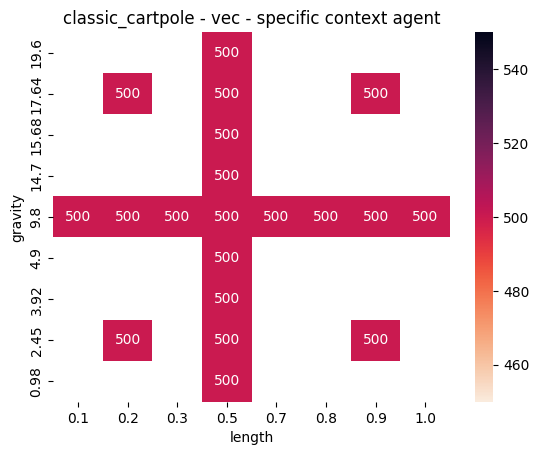

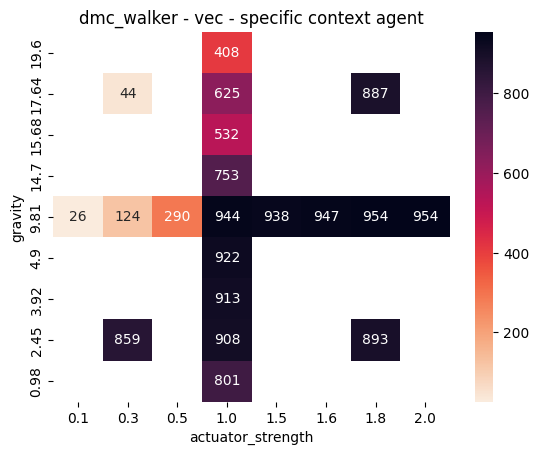

In [3]:
best_agent_metrics = get_best_agent_metrics()
save_dir = Path("./plots/")
plot_best_agent_metrics(best_agent_metrics, save_dir)

In [39]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns

TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}

def plot_violin_plots(task, context_idx, modality, save_dir, log_dir, best_agent_metrics, suffix="50k"):
    single_setting = f"single_{context_idx}"
    
    experiments = [
        log_dir / f"carl_{task}_default_enc_{modality}_dec_{modality}_{suffix}",
        log_dir / f"carl_{task}_{single_setting}_enc_{modality}_dec_{modality}_{suffix}",
        log_dir / f"carl_{task}_{single_setting}_enc_{modality}_ctx_dec_{modality}_ctx_{suffix}",
        log_dir / f"carl_{task}_{single_setting}_enc_{modality}_dec_{modality}_pgm_ctx_{suffix}",
    ] 
    exp_types = [
        "default", "w/o context", "obs context", "pgm context"
    ]
    modality = "vector" if modality == "obs" else "pixel"

    context_name = _TASK2CONTEXTS[task][context_idx]["context"]
    data = {
        "context": [],
        "experiment": [],
        "return": [],
    }
    seeds = 0
    for i, exp_path in enumerate(experiments):
        exp_type = exp_types[i]
        experiment = exp_path.name
        for seed_path in exp_path.iterdir():
            eval_file = seed_path / "eval.jsonl"
            if not eval_file.exists():
                continue
            seeds += 1
            with eval_file.open() as f:
                lines = f.readlines()
            lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
            for line in lines:
                if context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0:
                    ctx_value = line['ctx']["context"][context_name]
                    ret = float(line['return'])
                    data["context"].append(ctx_value)
                    data["experiment"].append(exp_type)
                    data["return"].append(ret)
    df = pd.DataFrame.from_dict(data)
    env = _TASK2ENV[task]

    default_context_val = env.get_default_context()[context_name]

    interpolate_range = _TASK2CONTEXTS[task][context_idx]["train_range"]
    split = True
    hue = "input"
    save_path = save_dir / f"{task}_{context_name}_{modality}.pdf"
    
    other_ctx_id = 1 - context_idx
    other_ctx_name = _TASK2CONTEXTS[task][other_ctx_id]["context"]
    other_default = env.get_default_context()[other_ctx_name]
    best_x = []
    best_y = []
    for ctx_val in best_agent_metrics[task]:
        if ctx_val[other_ctx_id] == other_default:
            best_x.append(ctx_val[context_idx])
            best_y.append(best_agent_metrics[task][ctx_val])
    # for each context_val in df, find nearest best_x, and use the best_y as the return for comparison
    best_x = np.array(best_x)
    best_y = np.array(best_y)
    best_xs = []
    best_ys = []
    for i, ctx_val in enumerate(df["context"].unique()):
        idx = np.argmin(np.abs(best_x - ctx_val))
        best_xs.append(ctx_val)
        best_ys.append(best_y[idx])
            
    plt.figure(figsize=(25,10))
    ax = sns.violinplot(data=df, x="context", y="return", hue="experiment", cut=0, native_scale=True, density_norm="width", width=0.75)
    plt.xlabel(context_name)
    
    # sort best_xs and best_ys by best_xs
    best_xs, best_ys = zip(*sorted(zip(best_xs, best_ys)))
    # plot a line for best xs and ys
    plt.step(best_xs, best_ys, color='C3', linestyle='--', where='mid', label="best agent")
    plt.xticks(df["context"].unique())
    plt.axvline(default_context_val, color='C2', linestyle='--', label="default context")
    plt.axvspan(interpolate_range[0], interpolate_range[1], facecolor='C2', alpha=0.1, label="interpolate range")
    
    # colors = []
    # for collection in ax.collections:
    #     if isinstance(collection, matplotlib.collections.PolyCollection):
    #         colors.append(collection.get_facecolor())
    #         collection.set_edgecolor(colors[-1])
    #         collection.set_facecolor('none')
    # if len(ax.lines) == 2 * len(colors):  # suppose inner=='box'
    #     for lin1, lin2, color in zip(ax.lines[::2], ax.lines[1::2], colors):
    #         lin1.set_color(color)
    #         lin2.set_color(color)
    # for h in ax.legend_.legendHandles:
    #     if isinstance(h, matplotlib.patches.Rectangle):
    #         h.set_edgecolor(h.get_facecolor())
    #         h.set_facecolor('none')
    #         h.set_linewidth(1.5)

    plt.legend()
    # add legend for the background
    # set the y axis to go from 0 to max return
    plt.ylim(0, TASK2MaxReturn[task] + 10)

    # Title should be task - modality - context_name
    # bold the context name
    title = f"{task} - {modality}"
    plt.title(title)
    plt.savefig(save_path)
    plt.pause(0.1)
    if seeds != 10:
        print(f"not enough seeds - {title} - {seeds}")        

/tmp/ipykernel_1452218/1098958777.py:105: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in ax.legend_.legendHandles:


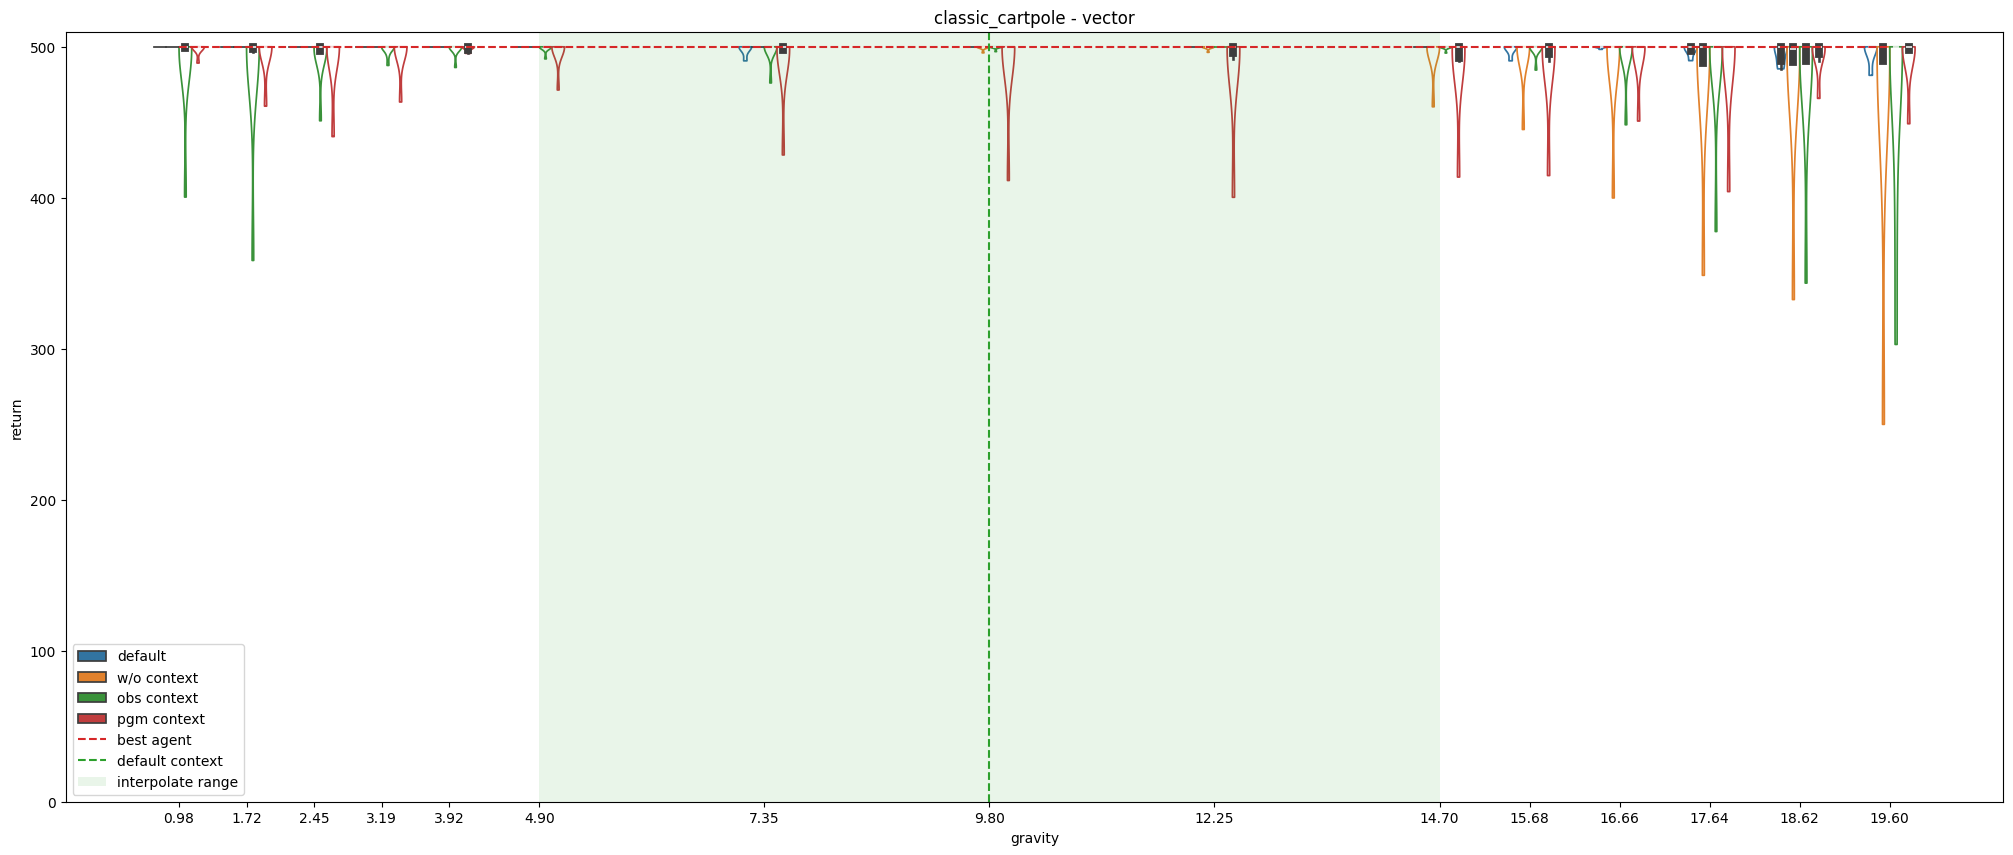

not enough seeds - classic_cartpole - vector - 30


/tmp/ipykernel_1452218/1098958777.py:105: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in ax.legend_.legendHandles:


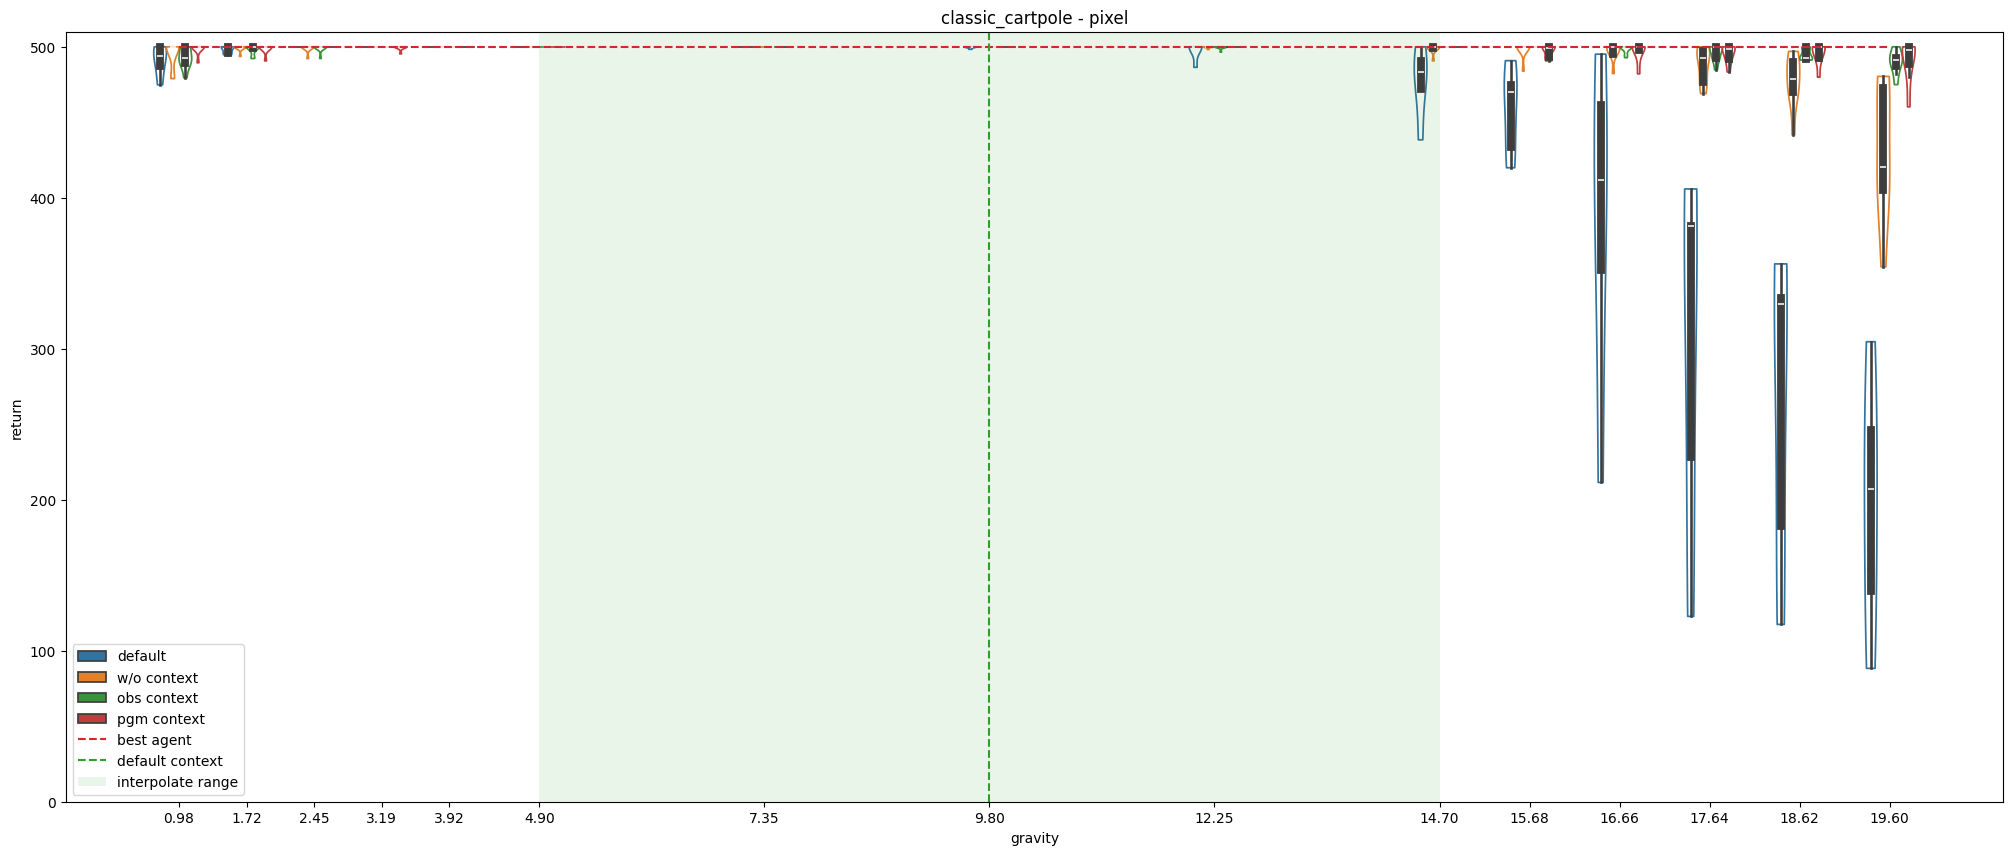

not enough seeds - classic_cartpole - pixel - 32


/tmp/ipykernel_1452218/1098958777.py:105: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in ax.legend_.legendHandles:


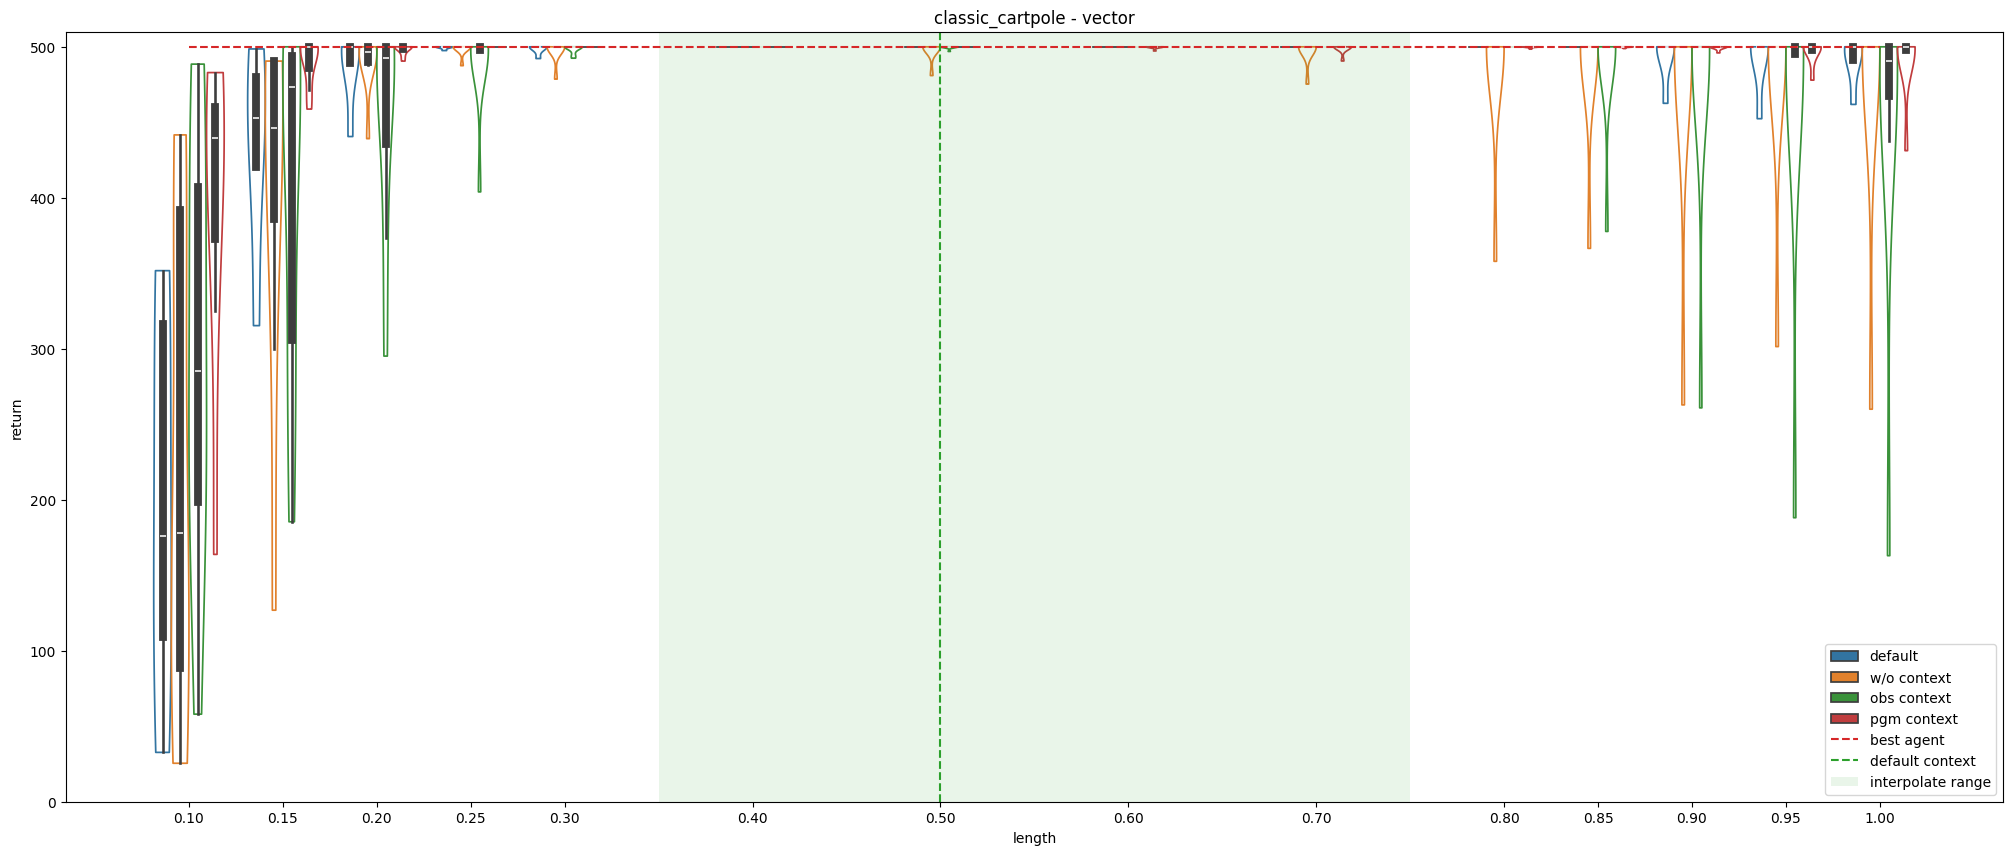

not enough seeds - classic_cartpole - vector - 30


/tmp/ipykernel_1452218/1098958777.py:105: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in ax.legend_.legendHandles:


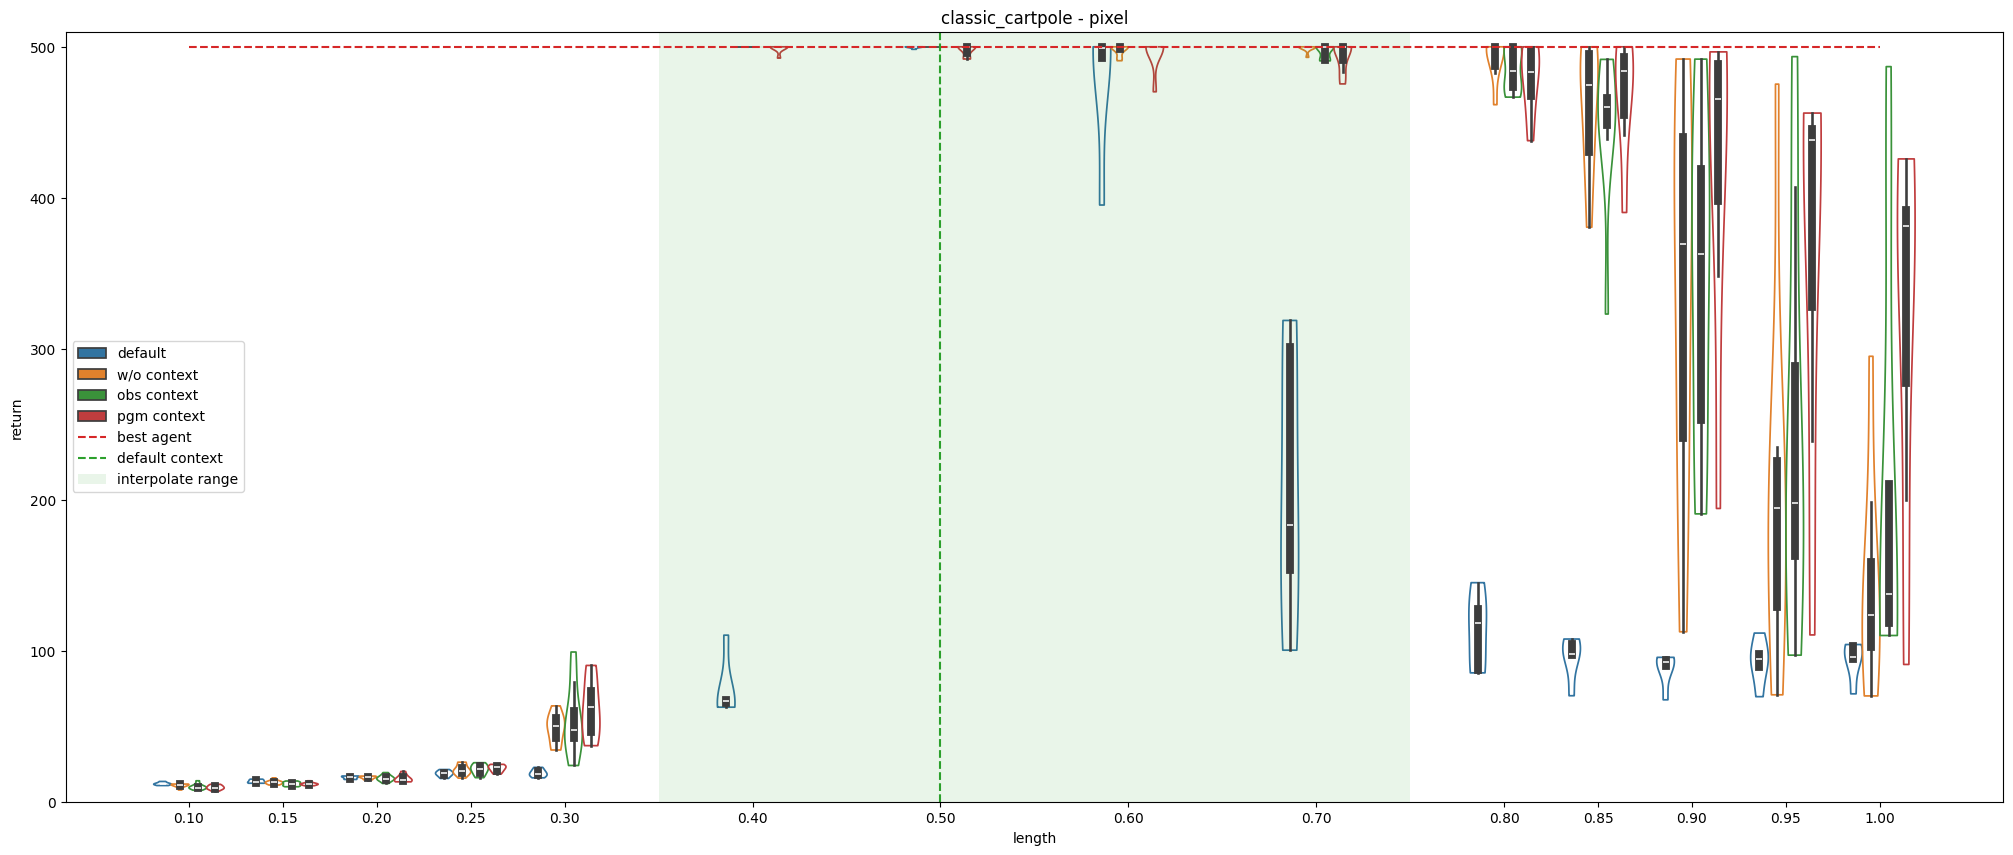

not enough seeds - classic_cartpole - pixel - 29


/tmp/ipykernel_1452218/1098958777.py:105: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in ax.legend_.legendHandles:


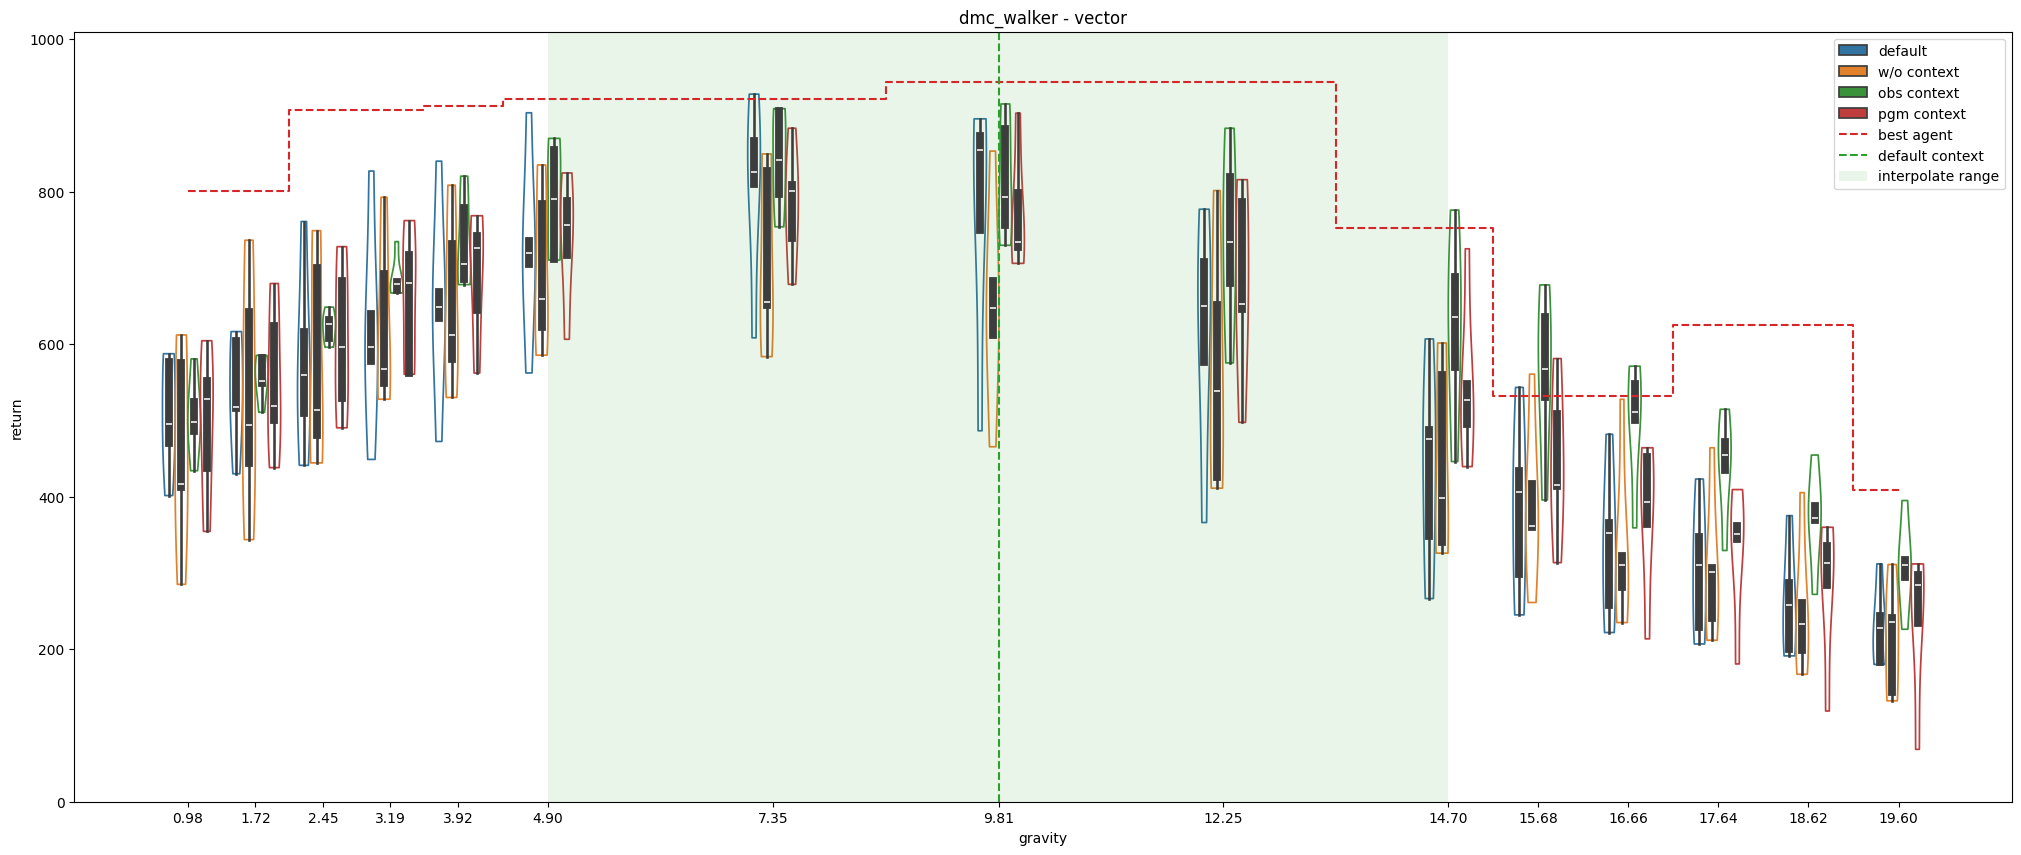

not enough seeds - dmc_walker - vector - 20


/tmp/ipykernel_1452218/1098958777.py:105: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in ax.legend_.legendHandles:


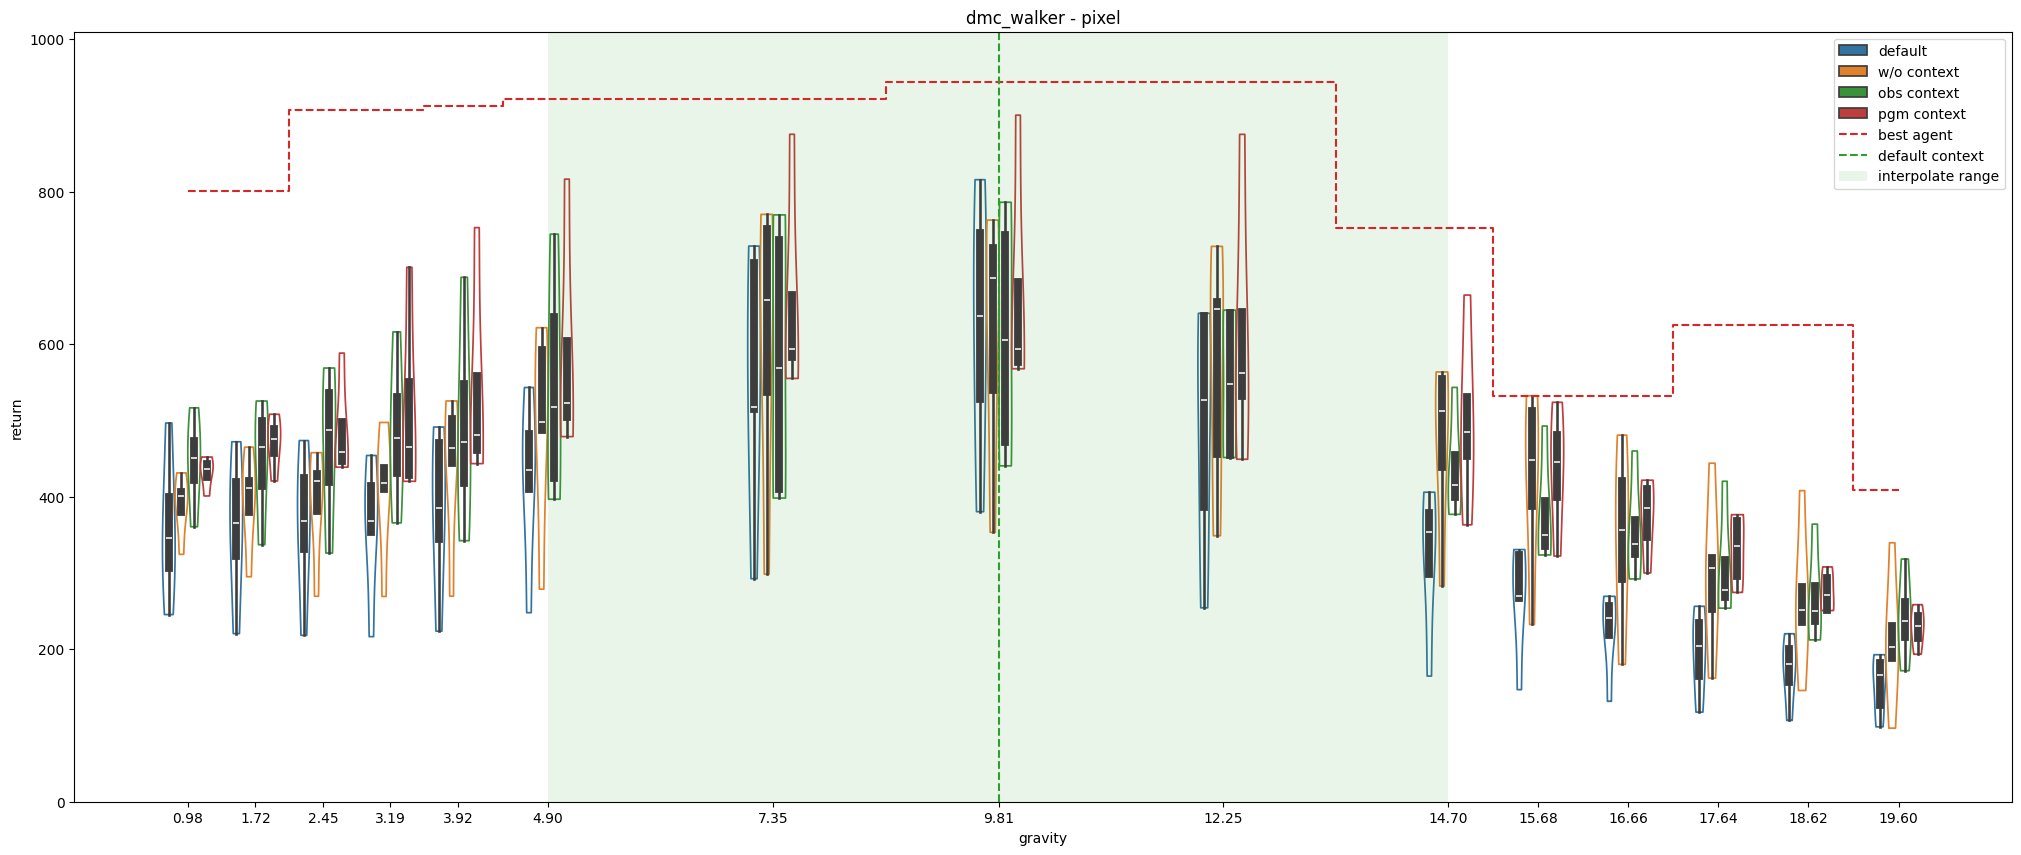

not enough seeds - dmc_walker - pixel - 18


/tmp/ipykernel_1452218/1098958777.py:105: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in ax.legend_.legendHandles:


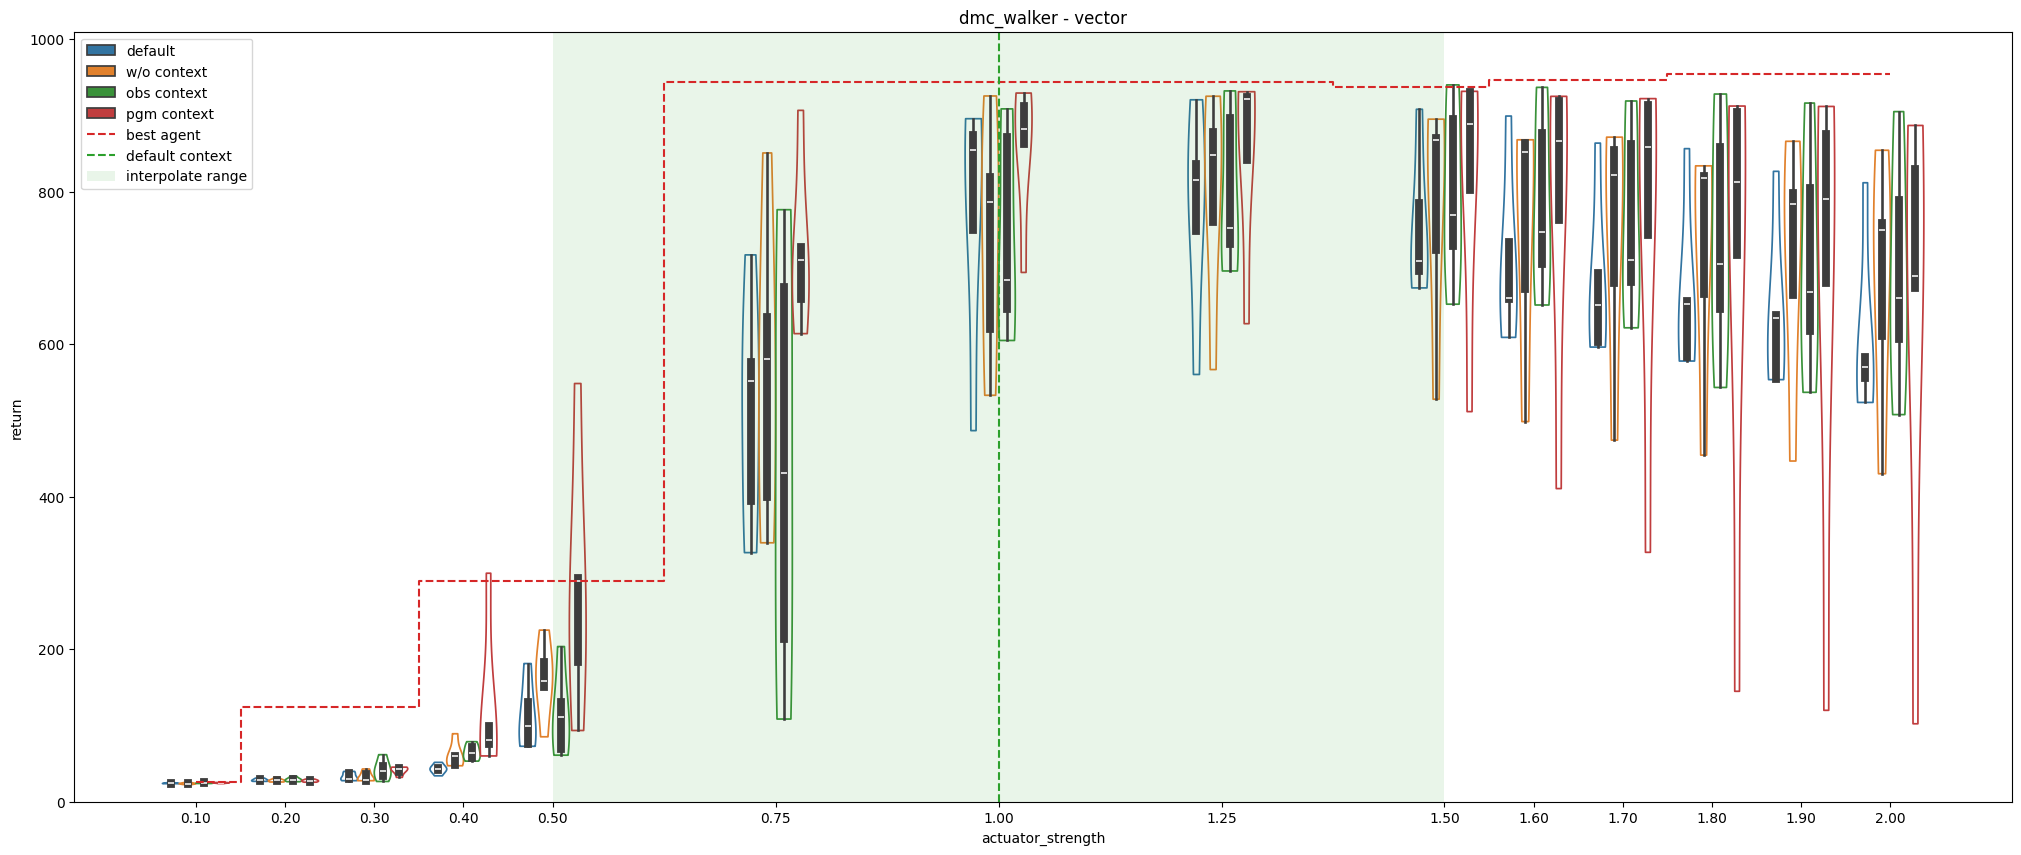

not enough seeds - dmc_walker - vector - 20


/tmp/ipykernel_1452218/1098958777.py:105: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in ax.legend_.legendHandles:


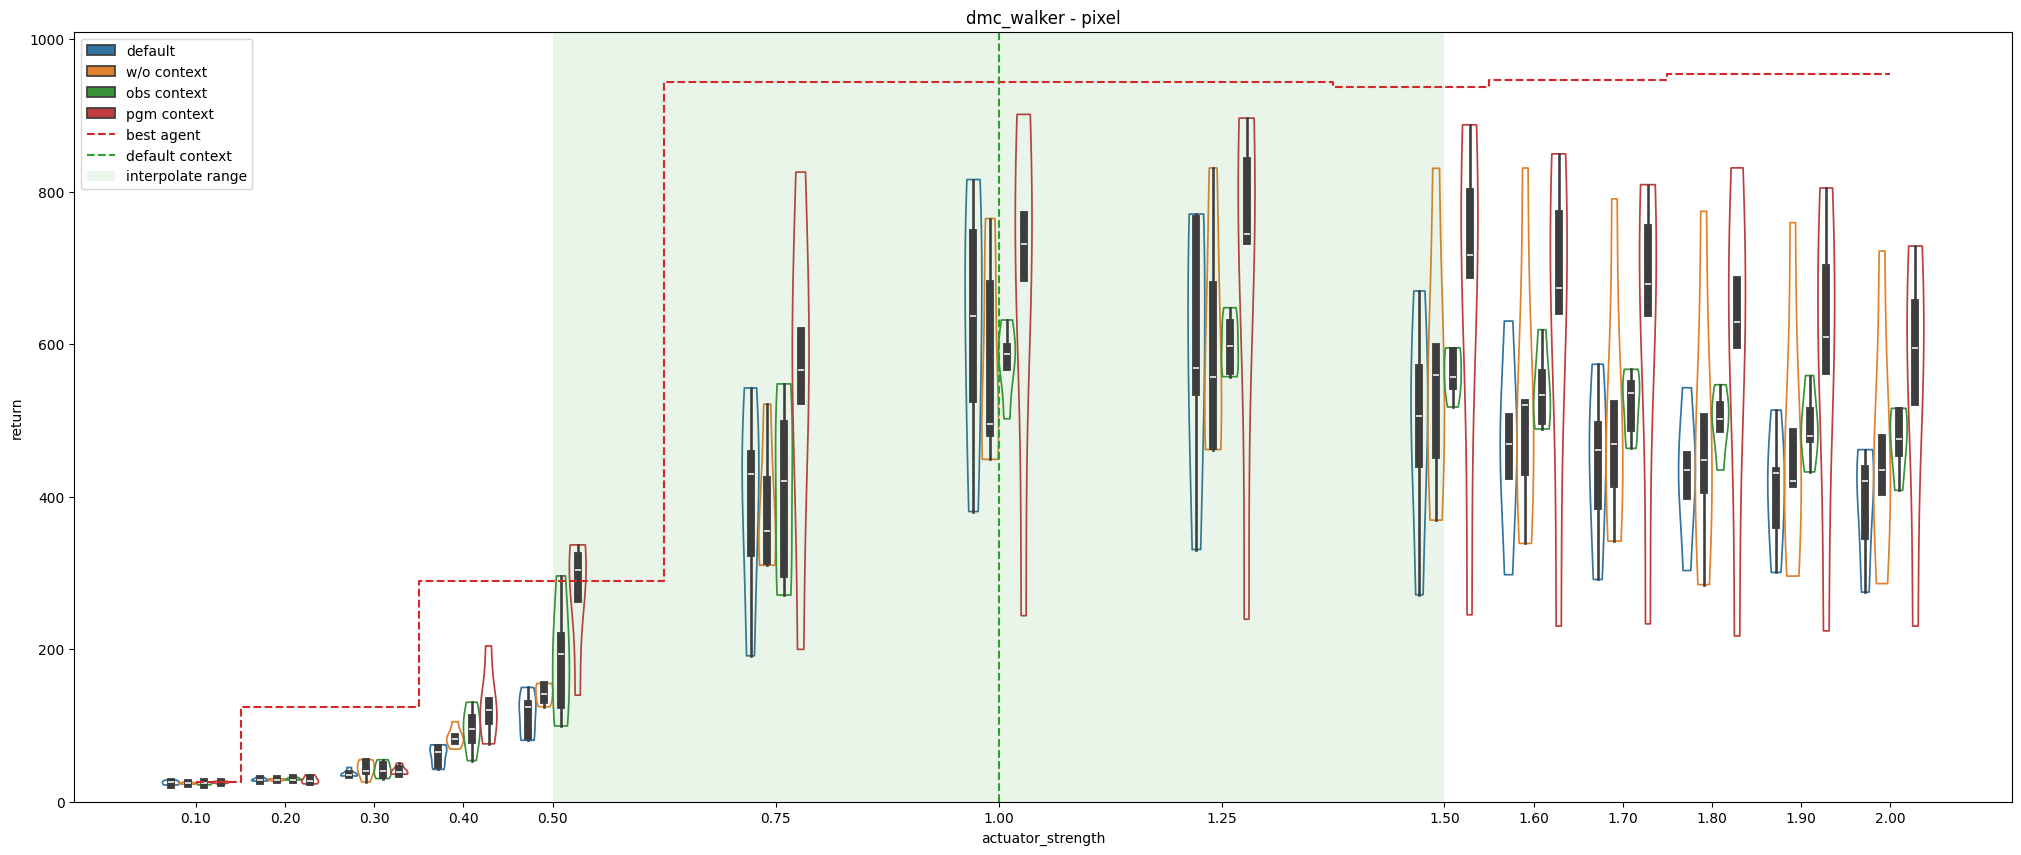

not enough seeds - dmc_walker - pixel - 20


In [40]:
tasks = ["classic_cartpole", "dmc_walker"]
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")

for task in tasks:
        for context_id in context_ids:
            for modality in modalities:
                plot_violin_plots(task, context_id, modality, save_dir, logdir, best_agent_metrics, "normalized")

In [41]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cdist
import numpy as np


def compute_regret(agent_metrics, best_agent_metrics):
    regret = {}
    min_ctx_0 = min([k[0] for k in agent_metrics])
    max_ctx_0 = max([k[0] for k in agent_metrics])
    min_ctx_1 = min([k[1] for k in agent_metrics])
    max_ctx_1 = max([k[1] for k in agent_metrics])
    normalized_best_keys = [
        ((k[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (k[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6)) for k in best_agent_metrics
    ]
    best_keys = list(best_agent_metrics.keys())
    
    for current_key, mean_return in agent_metrics.items():
        normalized_current_key = ((current_key[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (current_key[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6))
        distances = cdist([normalized_current_key], normalized_best_keys)
        nearest_index = np.argmin(distances)
        nearest_key = best_keys[nearest_index]
        nearest_best_return = best_agent_metrics[nearest_key]
        regret[current_key] = nearest_best_return - mean_return
    return regret

def compute_eval_regret(log_dir, task, train_setting, context_idx, modality, ctx_type, best_agent_metrics, t_step="50k"):
    assert train_setting in ["default", "single", "double_box"]
    assert train_setting != "double_box" or context_idx is None
    train_setting_full = train_setting
    metric_context_name = None
    if train_setting == "single":
        train_setting_full = f"{train_setting}_{context_idx}"
    if context_idx is not None:
        metric_context_name = _TASK2CONTEXTS[task][context_idx]["context"]

    
    if ctx_type == "no_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_{t_step}"
    elif ctx_type == "enc_dec_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_ctx_dec_{modality}_ctx_{t_step}"
    elif ctx_type == "pgm_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_pgm_ctx_{t_step}"
    else:
        raise RuntimeError("invalid ctx")

    modality = "vector" if modality == "obs" else "pixel"
    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]
    env = _TASK2ENV[task]
    default_0 = env.get_default_context()[ctx_0]
    default_1 = env.get_default_context()[ctx_1]
    current_metrics = defaultdict(list)
    for seed_path in exp_path.iterdir():
        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        for line in lines:
            ctx_0_val, ctx_1_val = line['ctx']["context"][ctx_0], line['ctx']["context"][ctx_1]
            ret = float(line['return'])
            if train_setting == "double_box" or (train_setting == "default" and context_idx is None)  or (metric_context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0):
                current_metrics[(ctx_0_val, ctx_1_val)].append(ret)
    agent_metrics = {k: np.mean(v) for k, v in current_metrics.items()}
    
    best_metrics = best_agent_metrics[task]
    regret = compute_regret(agent_metrics, best_metrics)
    
    interpolate_ranges = [
        [default_0, default_0 + 1e-6],
        [default_1, default_1 + 1e-6]
    ]
    if context_idx is not None and (train_setting == "single":
        interpolate_ranges[context_idx] = _TASK2CONTEXTS[task][context_idx]["train_range"]
    elif train_setting == "double_box":
        interpolate_ranges[0] = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_ranges[1] = _TASK2CONTEXTS[task][1]["train_range"]
    interpolate_regret = []
    extrapolate_regret = []
    inter_extrapolate_regret = []
    for ctx_key in regret:
        if (ctx_key[0] >= interpolate_ranges[0][0] and ctx_key[0] <= interpolate_ranges[0][1]) and (ctx_key[1] >= interpolate_ranges[1][0] and ctx_key[1] <= interpolate_ranges[1][1]):
            interpolate_regret.append(regret[ctx_key])
        elif train_setting != "double_box" or (ctx_key[0] < interpolate_ranges[0][0] or ctx_key[0] > interpolate_ranges[0][1]) and (ctx_key[1] < interpolate_ranges[1][0] or ctx_key[1] > interpolate_ranges[1][1]):
            extrapolate_regret.append(regret[ctx_key])
        else:
            inter_extrapolate_regret.append(regret[ctx_key])
    print(f"{task}, {train_setting}, {metric_context_name or f'{ctx_0}-{ctx_1}'}, {modality}, {ctx_type}, {np.mean(interpolate_regret)}, {np.mean(extrapolate_regret)}, {np.mean(inter_extrapolate_regret)}, {np.mean(interpolate_regret + extrapolate_regret + inter_extrapolate_regret)}")

In [45]:

tasks = ["classic_cartpole", "dmc_walker"]
train_settings = ["default", "single", "double_box"] # default context, varying single context in a interpolation range 
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")

print("Task, train_setting, context, modality, inputs, interpolate regret, extrapolate regret, inter-extra regret, average regret")
for task in tasks:
    for setting in ["single", "double_box"]:
        if setting == "single":
            context_ids = [0, 1]
        else:
            context_ids = [None]
        for ctx_id in context_ids:
            for modality in modalities:
                compute_eval_regret(logdir, task, "default", ctx_id, modality, "no_ctx", best_agent_metrics, "normalized")
                for ctx_type in ["no_ctx", "enc_dec_ctx", "pgm_ctx"]:
                    compute_eval_regret(logdir, task, setting, ctx_id, modality, ctx_type, best_agent_metrics, "normalized")
                print("\n")

Task, train_setting, context, modality, inputs, interpolate regret, extrapolate regret, inter-extra regret, average regret
classic_cartpole, default, gravity, vector, no_ctx, 0.0, 1.0723186813186893, nan, 1.0008307692307767
classic_cartpole, single, gravity, vector, no_ctx, 1.2022884615384555, 10.466115384615382, nan, 7.378173076923073
classic_cartpole, single, gravity, vector, enc_dec_ctx, 0.8967863247863079, 11.651170940170932, nan, 8.066376068376057
classic_cartpole, single, gravity, vector, pgm_ctx, 12.435461538461539, 13.99539423076925, nan, 13.47541666666668


classic_cartpole, default, gravity, pixel, no_ctx, 0.33076923076924913, 66.25223076923076, nan, 61.85746666666666
classic_cartpole, single, gravity, pixel, no_ctx, 0.298717948717956, 11.314649572649586, nan, 7.642672364672376
classic_cartpole, single, gravity, pixel, enc_dec_ctx, 0.07735042735043862, 3.003043405396352, nan, 2.027812412714381
classic_cartpole, single, gravity, pixel, pgm_ctx, 0.0, 2.799516025641026, nan, 1.8

In [73]:
import json
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import argparse
from scipy.stats import sem
from pathlib import Path
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle


def plot2d(logdir, save_dir, task, modality, train_mode, ctx, exp_suffix):


    data = defaultdict(list)


    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]

    if train_mode == "default":
        env = _TASK2ENV[task]
        default_0 = env.get_default_context()[ctx_0]
        default_1 = env.get_default_context()[ctx_1]
        interpolate_range_0 = [default_0, default_0]
        interpolate_range_1 = [default_1, default_1]
    else:
        interpolate_range_0 = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_range_1 = _TASK2CONTEXTS[task][1]["train_range"]

    if ctx == "no_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_dec_{modality}_{exp_suffix}"
    elif ctx == "enc_dec_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_ctx_dec_{modality}_ctx_{exp_suffix}"
    elif ctx == "enc_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_ctx_dec_{modality}_{exp_suffix}"
    else:
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_dec_{modality}_ctx_{exp_suffix}"
    modality = "vector" if modality == "obs" else "pixel"
    seeds = 0
    experiment = exp_path.name
    for seed_path in exp_path.iterdir():
        seed = int(seed_path.name)
        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        seeds += 1
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        for line in lines:
            
            ctx_0_value = line['ctx']["context"][ctx_0]
            ctx_1_value = line['ctx']["context"][ctx_1]
            ret = float(line['return'])
            data[(ctx_0_value, ctx_1_value)].append(ret)


    x = []
    y = []
    c = []
    for ctx_0_value, ctx_1_value in data:
        x.append(ctx_0_value)
        y.append(ctx_1_value)
        c.append(np.mean(data[(ctx_0_value, ctx_1_value)]))


    df = pd.DataFrame({ctx_0: x, ctx_1: y, "return": c})
    df = df.pivot(index=ctx_0, columns=ctx_1, values="return")
    
    # sort the rows descending
    df = df.sort_index(ascending=False)

    
    # darker colors for higher values, red color map
    ax = sns.heatmap(df, cmap=sns.cm.rocket_r, annot=True, fmt=".0f")
    

    h_index_0 = df.index.searchsorted(interpolate_range_0[0], 'left', df.index.argsort())
    h_index_1 = df.index.searchsorted(interpolate_range_0[1], 'right', df.index.argsort())

    v_index_0 = df.columns.searchsorted(interpolate_range_1[0], 'left')
    v_index_1 = df.columns.searchsorted(interpolate_range_1[1], 'right')
    
    ax.add_patch(Rectangle((v_index_0, h_index_0), (v_index_1 - v_index_0), (h_index_1 - h_index_0), fill=False, edgecolor='g', linestyle='--', linewidth=2))
    plt.title(f"{task} - {modality} - {ctx}")
    
    plt.savefig(save_dir / f"{task}_{train_mode}_{modality}_{ctx}.pdf")
    
    if seeds != 5:
        print(f"not enough seeds - {task} - {modality} - {ctx} - {seeds}")
    
    # clear plt
    plt.pause(0.1)
    return df

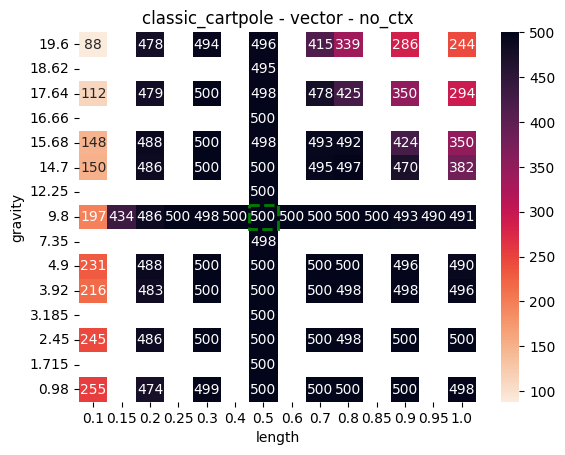

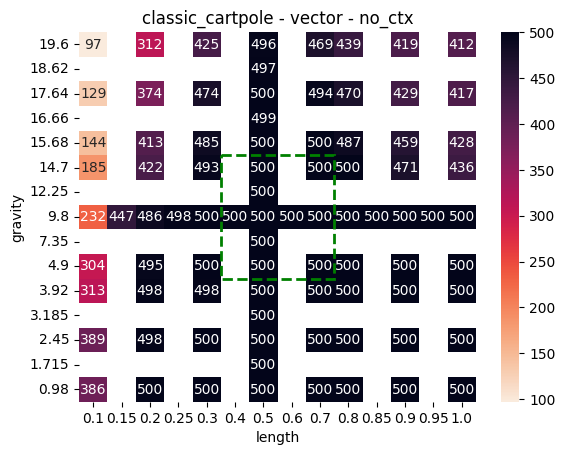

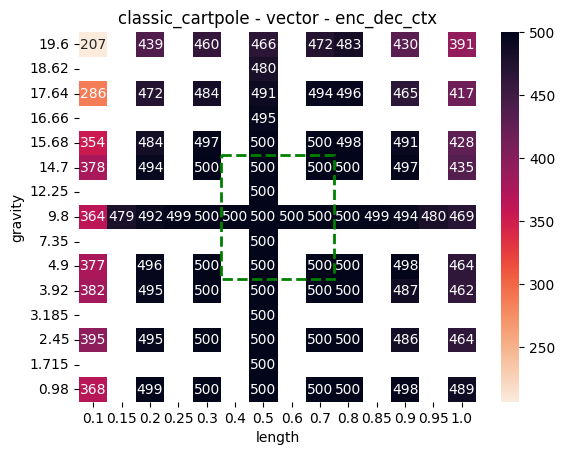

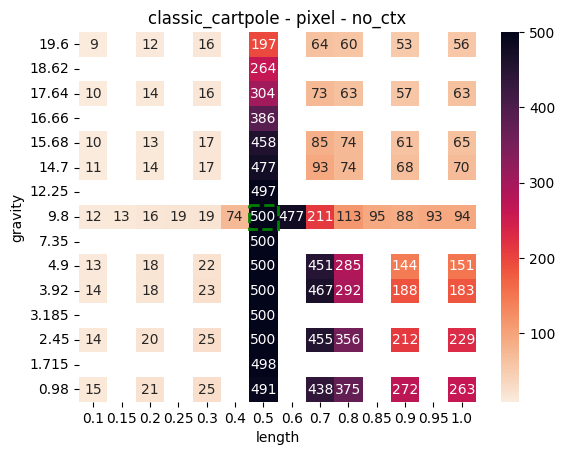

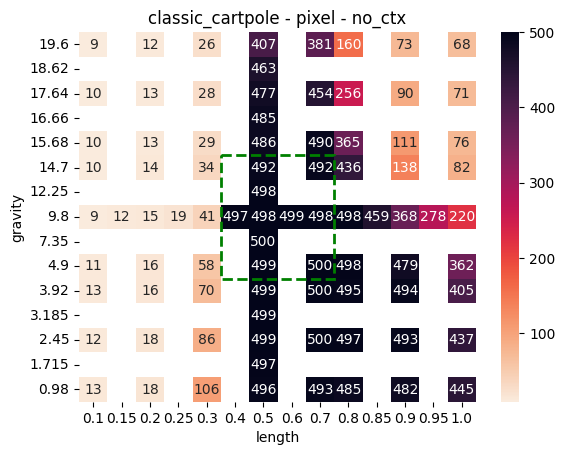

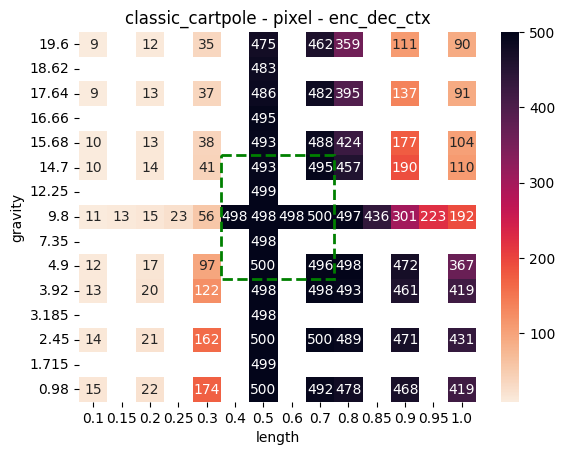

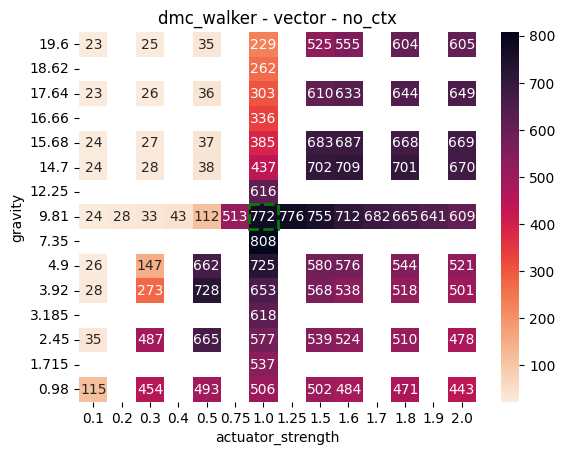

not enough seeds - dmc_walker - vector - no_ctx - 4


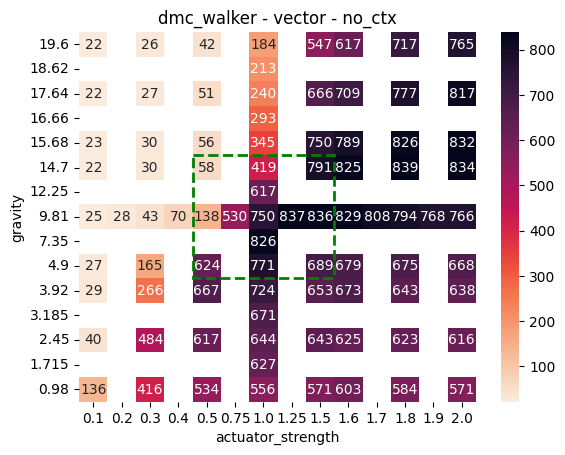

not enough seeds - dmc_walker - vector - enc_dec_ctx - 4


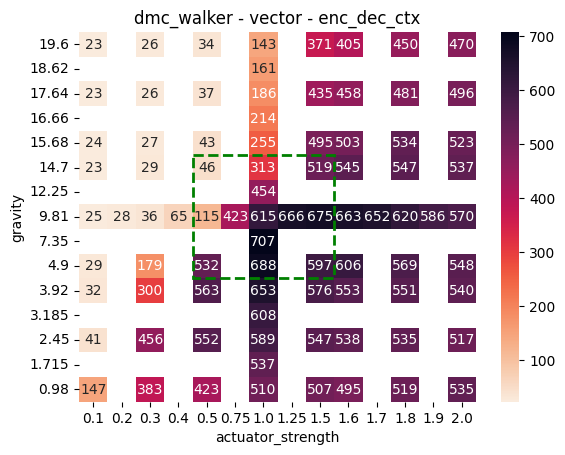

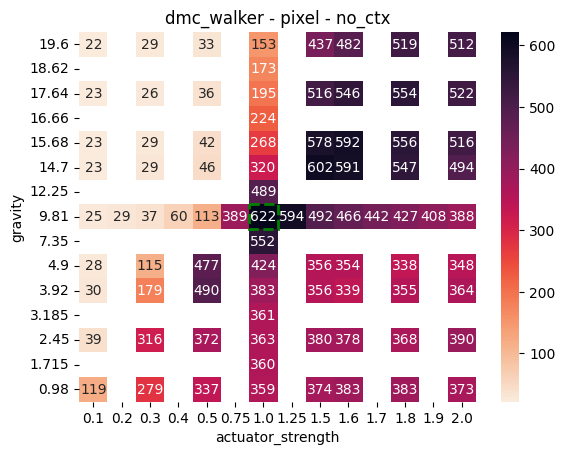

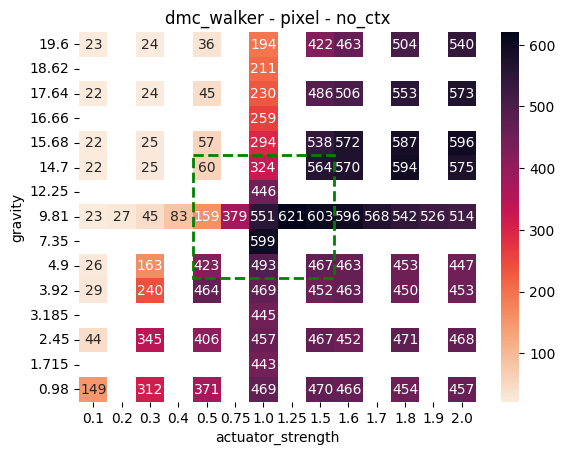

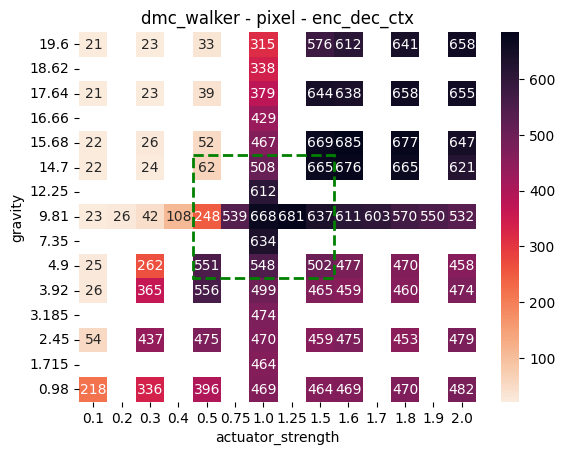

In [26]:
exp_suffix = "normalized"
tasks = ["classic_cartpole", "dmc_walker"]
modalities = ["obs", "img"]
train_modes = ["default", "double_box"]
logdir = Path("../logs") 

save_dir = Path("./plots/")
for task in tasks:
    for modality in modalities:
        for train_mode in train_modes:
            plot2d(logdir, save_dir, task, modality, train_mode, "no_ctx", exp_suffix)
            if train_mode == "double_box":
                plot2d(logdir, save_dir, task, modality, train_mode, "enc_dec_ctx", exp_suffix)                


In [118]:
compute_eval_regret(logdir, task, train_setting, context_id, modality, ctx_type, best_agent_metrics, "normalized")

(4.9, 1.0) 547.8976076984867 (4.9, 1.0) 922.2819315818958
(7.35, 1.0) 634.0154444503181 (4.9, 1.0) 922.2819315818958
(9.81, 1.0) 668.2891853854791 (9.81, 1.0) 944.411571765061
(12.25, 1.0) 611.5887015104836 (9.81, 1.0) 944.411571765061
(14.7, 1.0) 508.18916338617345 (14.7, 1.0) 752.9832866181252
(0.98, 1.0) 469.12876974944686 (0.98, 1.0) 801.4256003150032
(1.715, 1.0) 463.987208604201 (0.98, 1.0) 801.4256003150032
(2.45, 1.0) 470.4159718198495 (2.45, 1.0) 907.5754602674793
(3.185, 1.0) 473.89344137328396 (2.45, 1.0) 907.5754602674793
(3.92, 1.0) 499.0216433987631 (3.92, 1.0) 912.6257066073997
(15.68, 1.0) 467.0178335297969 (15.68, 1.0) 532.4455512155523
(16.66, 1.0) 428.73223302310436 (15.68, 1.0) 532.4455512155523
(17.64, 1.0) 378.57016488312155 (17.64, 1.0) 624.850575443205
(18.62, 1.0) 338.0650051126337 (17.64, 1.0) 624.850575443205
(19.6, 1.0) 314.99899248444666 (19.6, 1.0) 408.3641663919418
(9.81, 0.5) 247.9545957684526 (9.81, 0.5) 289.9274517451794
(9.81, 0.75) 538.9768097246849 

In [119]:
np.linalg.norm(np.array([19.6, 2.0]) - np.array([19.6, 1.0]))

1.0

In [120]:
np.linalg.norm(np.array([19.6, 2.0]) - np.array([17.64, 1.8]))

1.970177656963961